In [3]:
# Clustering the users on the basis of their purchase

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')
prior_orders = pd.read_csv('../input/order_products__prior.csv')
train_orders = pd.read_csv('../input/order_products__train.csv')
orders = pd.read_csv('../input/orders.csv')
products = pd.read_csv('../input/products.csv')

In [5]:
def data_prep_apriori(prior_orders, train_orders, aisles, departments):
    concat_orders = pd.concat([prior_orders,train_orders],axis = 0).merge(products[['product_id','aisle_id','department_id']], how = 'inner', on = 'product_id').merge(aisles, on = 'aisle_id').merge(departments, on = 'department_id').merge(orders[['order_id','user_id']], on = 'order_id')
    aisle_history = concat_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
    dept_history = concat_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()
    user_volume = aisle_history.groupby('user_id')['add_to_cart_order'].sum()
    user_volume = user_volume.reset_index().rename(columns = {'add_to_cart_order':'volume'})
    aisle_history = aisle_history.merge(user_volume, how = 'inner', on = 'user_id')
    dept_history = dept_history.merge(user_volume, how = 'inner', on = 'user_id')
    aisle_history['aisle_share'] = aisle_history['add_to_cart_order'] / aisle_history['volume']
    dept_history['dept_share'] = dept_history['add_to_cart_order'] / dept_history['volume']
    aisle_vol_pivot = aisle_history[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
    aisle_share_pivot = aisle_history[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
    dept_vol_pivot = dept_history[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
    dept_share_pivot = dept_history[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')
    aisle_vol_pivot = aisle_vol_pivot.fillna(value = 0)
    aisle_share_pivot = aisle_share_pivot.fillna(value = 0)
    dept_vol_pivot = dept_vol_pivot.fillna(value = 0)
    dept_share_pivot = dept_share_pivot.fillna(value = 0)

    return concat_orders, aisle_history, dept_history, aisle_share_pivot, dept_share_pivot, aisle_vol_pivot, dept_vol_pivot



# Preparing data for Kmeans clustering

In [6]:
concat_orders = pd.concat([prior_orders,train_orders],axis = 0)
concat_orders = concat_orders.merge(products[['product_id','aisle_id','department_id']], how = 'inner', on = 'product_id')
concat_orders = concat_orders.merge(aisles, on = 'aisle_id')
concat_orders = concat_orders.merge(departments, on = 'department_id')
concat_orders = concat_orders.merge(orders[['order_id','user_id']], on = 'order_id')

In [7]:
aisle_history = concat_orders[['user_id','add_to_cart_order','aisle']].groupby(['user_id','aisle']).sum().reset_index()
dept_history = concat_orders[['user_id','add_to_cart_order','department']].groupby(['user_id','department']).sum().reset_index()

In [8]:
user_volume = aisle_history.groupby('user_id')['add_to_cart_order'].sum()
user_volume = user_volume.reset_index().rename(columns = {'add_to_cart_order':'volume'})
aisle_history = aisle_history.merge(user_volume, how = 'inner', on = 'user_id')
dept_history = dept_history.merge(user_volume, how = 'inner', on = 'user_id')

In [9]:
aisle_history['aisle_share'] = aisle_history['add_to_cart_order'] / aisle_history['volume']
dept_history['dept_share'] = dept_history['add_to_cart_order'] / dept_history['volume']

In [10]:
aisle_vol_pivot = aisle_history[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
aisle_share_pivot = aisle_history[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
dept_vol_pivot = dept_history[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
dept_share_pivot = dept_history[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')

In [11]:
aisle_vol_pivot = aisle_history[['user_id','aisle','add_to_cart_order']].pivot(index = 'user_id', columns = 'aisle', values = 'add_to_cart_order')
aisle_share_pivot = aisle_history[['user_id','aisle','aisle_share']].pivot(index = 'user_id', columns = 'aisle', values = 'aisle_share')
dept_vol_pivot = dept_history[['user_id','department','add_to_cart_order']].pivot(index = 'user_id', columns = 'department', values = 'add_to_cart_order')
dept_share_pivot = dept_history[['user_id','department','dept_share']].pivot(index = 'user_id', columns = 'department', values = 'dept_share')

In [ ]:
aisle_vol_pivot = aisle_vol_pivot.fillna(value = 0)
aisle_share_pivot = aisle_share_pivot.fillna(value = 0)
dept_vol_pivot = dept_vol_pivot.fillna(value = 0)
dept_share_pivot = dept_share_pivot.fillna(value = 0)

In [12]:
concat_orders

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id
0,2,33120,1,1,86,16,eggs,dairy eggs,202279
1,2,28985,2,1,83,4,fresh vegetables,produce,202279
2,2,17794,6,1,83,4,fresh vegetables,produce,202279
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279
4,2,9327,3,0,104,13,spices seasonings,pantry,202279
...,...,...,...,...,...,...,...,...,...
33819101,1015358,46477,1,0,6,2,other,other,27208
33819102,647259,36631,1,0,6,2,other,other,17880
33819103,2010951,16161,1,0,6,2,other,other,62266
33819104,2684414,1013,1,0,6,2,other,other,69235


In [13]:
prior_orders

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [14]:
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.017857,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.025000
2,0.00000,0.010628,0.000000,0.0,0.000000,0.0,0.004159,0.00000,0.0,0.0,...,0.023105,0.003235,0.006932,0.000000,0.00000,0.000000,0.0,0.008318,0.0,0.186229
3,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.038363,0.012788,0.000000,0.000000,0.00000,0.000000,0.0,0.028133,0.0,0.000000
4,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.060000,0.00000,0.000000,0.0,0.040000,0.0,0.000000
5,0.02008,0.076305,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.064257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,0.00000,0.000000,0.009828,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.228501
206206,0.00000,0.021958,0.000000,0.0,0.000000,0.0,0.012809,0.00183,0.0,0.0,...,0.003660,0.000000,0.000000,0.000000,0.00000,0.003660,0.0,0.004575,0.0,0.000000
206207,0.00000,0.000000,0.000000,0.0,0.011862,0.0,0.000000,0.00000,0.0,0.0,...,0.008252,0.022692,0.000000,0.012893,0.00722,0.000000,0.0,0.033522,0.0,0.053120


Performing PCA analysis to reduce features

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

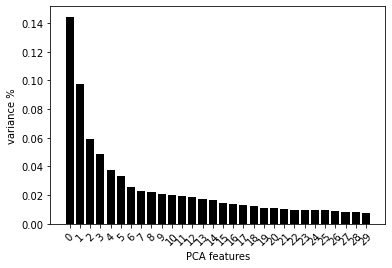

In [16]:
pca = PCA(n_components = 30)
principalComponents = pca.fit_transform(aisle_share_pivot)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.xticks(rotation = 45)

PCA_components = pd.DataFrame(principalComponents)

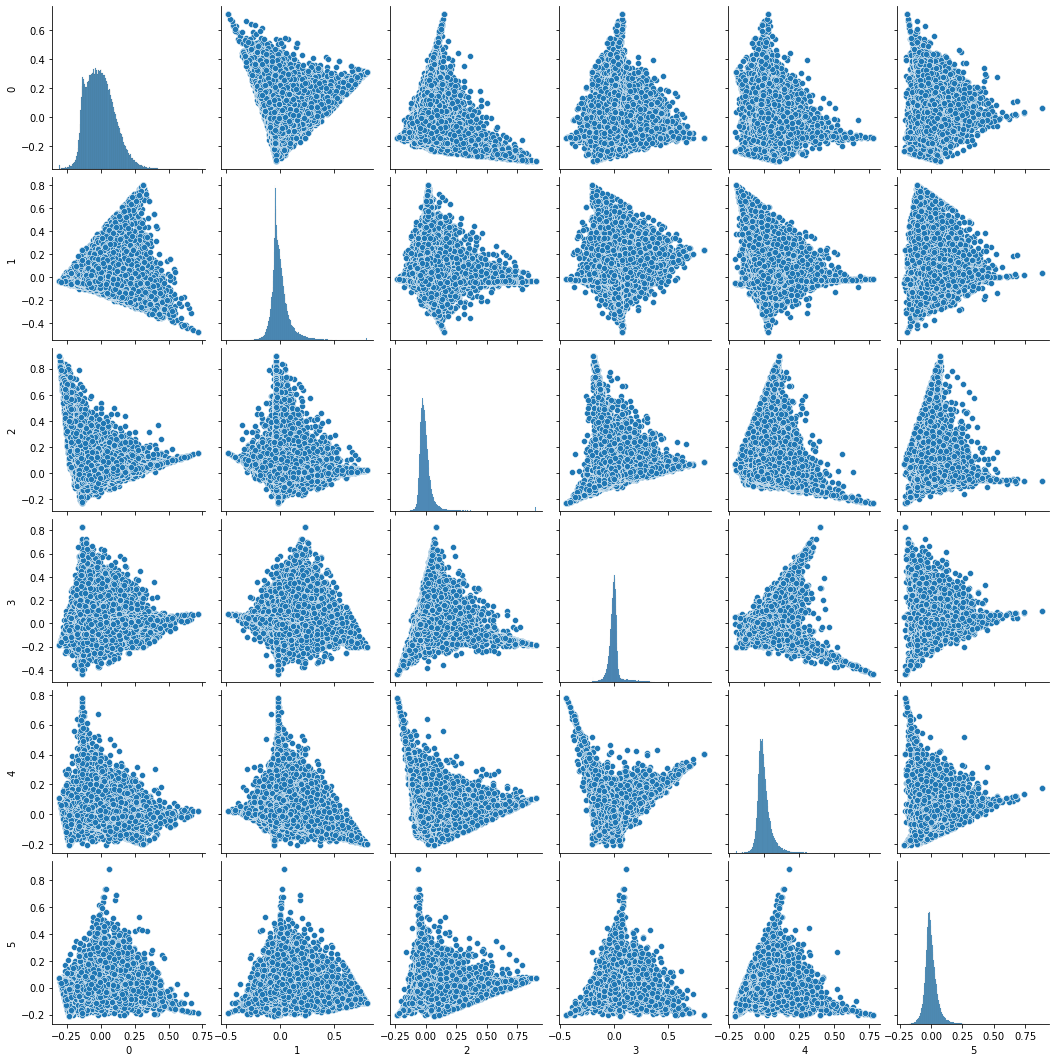

In [17]:
sns.pairplot(PCA_components[[0,1,2,3,4,5]])

Performing kmeans clustering

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

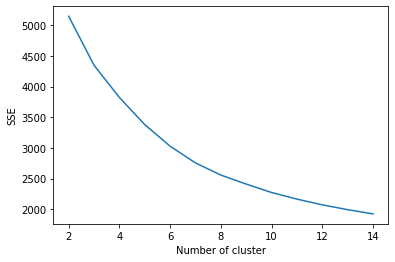

In [19]:
sse = {}
labels = {}
for k in range(2,15):
    kmeans = KMeans(n_clusters = k).fit(PCA_components[[0,1,2,3,4,5]])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [20]:
cluster_df = pd.concat([PCA_components[[0,1,2,3,4,5]],pd.Series(labels[6]).rename('cluster')], axis = 1)

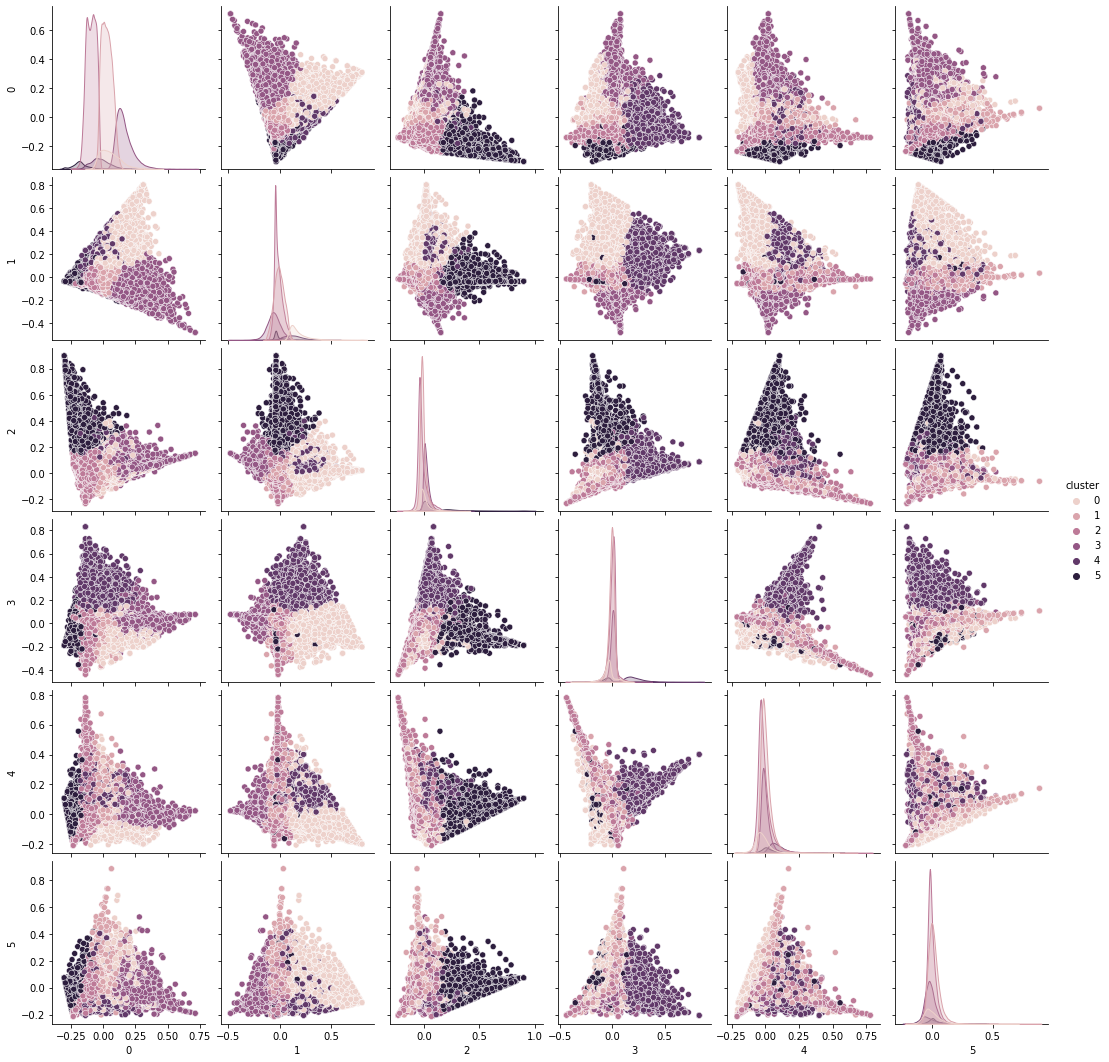

In [21]:
sns.pairplot(cluster_df, hue = 'cluster')

## Analysing the characterstics of clusters

In [22]:
cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)

In [23]:
cluster_df

,user_id,0,1,2,3,4,5,cluster
0,1,-0.103161,0.048617,-0.031839,-0.005641,-0.053010,-0.055237,2
1,2,-0.077766,0.077983,-0.076148,-0.101672,0.081783,-0.040413,2
2,3,0.057496,0.085719,0.001778,-0.013192,-0.028501,0.113069,1
3,4,-0.055343,0.134731,-0.002393,-0.037707,-0.087802,-0.027370,0
4,5,0.133936,-0.019591,-0.020960,-0.003732,0.057738,0.138888,1
...,...,...,...,...,...,...,...,...
206204,206205,-0.021674,0.081783,-0.073480,-0.088441,0.155972,-0.022705,1
206205,206206,-0.040316,-0.036658,-0.024048,0.010055,-0.050993,0.000816,2
206206,206207,-0.022110,-0.032613,-0.009467,-0.015800,0.021494,0.020461,1
206207,206208,-0.002217,-0.010633,-0.037621,-0.007753,0.028741,0.044834,1


In [25]:
aisle_history

,user_id,aisle,add_to_cart_order,volume,aisle_share
0,1,candy chocolate,8,280,0.028571
1,1,cereal,26,280,0.092857
2,1,cream,17,280,0.060714
3,1,fresh fruits,30,280,0.107143
4,1,milk,9,280,0.032143
...,...,...,...,...,...
5919835,206209,soft drinks,26,912,0.028509
5919836,206209,soy lactosefree,20,912,0.021930
5919837,206209,spices seasonings,9,912,0.009868
5919838,206209,trash bags liners,6,912,0.006579


In [26]:
cluster_aisle_br = aisle_history.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [27]:
cluster_aisle_br = cluster_aisle_br.rename(columns = {'aisle_share':'user_aisle_share'})

In [28]:
aisle_hist = aisle_history.merge(cluster_df[['user_id','cluster']], on = 'user_id')
aisle_hist = aisle_hist.rename(columns = {'aisle_share':'user_aisle_share'})

In [29]:
dept_hist = aisle_history.merge(cluster_df[['user_id','cluster']], on = 'user_id')
dept_hist = dept_hist.rename(columns = {'dept_share':'user_dept_share'})

In [30]:
cluster_aisle_br = pd.DataFrame(columns = ['aisle','add_to_cart_order','aisle_share','cluster'])
for i in range(0,6):
    x = aisle_hist[aisle_hist['cluster'] == i]
    x = x.groupby('aisle')['add_to_cart_order'].sum().reset_index()
    x['aisle_share'] = x['add_to_cart_order']
    x['aisle_share'] = x['aisle_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_aisle_br = pd.concat([x,cluster_aisle_br], axis = 0)

In [31]:
cluster_aisle_br

,aisle,add_to_cart_order,aisle_share,cluster
0,air fresheners candles,1006,0.000985,5
1,asian foods,3156,0.003089,5
2,baby accessories,108,0.000106,5
3,baby bath body care,72,0.000070,5
4,baby food formula,1180,0.001155,5
...,...,...,...,...
129,trash bags liners,5624,0.000541,0
130,vitamins supplements,12157,0.001169,0
131,water seltzer sparkling water,217689,0.020934,0
132,white wines,2072,0.000199,0


In [32]:
aisle_hist

,user_id,aisle,add_to_cart_order,volume,user_aisle_share,cluster
0,1,candy chocolate,8,280,0.028571,2
1,1,cereal,26,280,0.092857,2
2,1,cream,17,280,0.060714,2
3,1,fresh fruits,30,280,0.107143,2
4,1,milk,9,280,0.032143,2
...,...,...,...,...,...,...
5919835,206209,soft drinks,26,912,0.028509,2
5919836,206209,soy lactosefree,20,912,0.021930,2
5919837,206209,spices seasonings,9,912,0.009868,2
5919838,206209,trash bags liners,6,912,0.006579,2


In [33]:
t20 = list(aisle_hist.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)[0:20].index)
t30 = list(aisle_hist.groupby('aisle')['add_to_cart_order'].sum().sort_values(ascending = False)[0:30].index)

<AxesSubplot:xlabel='cluster', ylabel='aisle'>

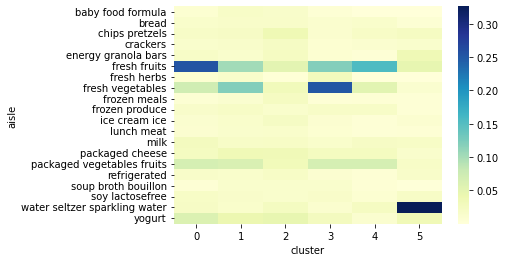

In [34]:
aisle_heat = cluster_aisle_br[cluster_aisle_br['aisle'].isin(t20)]
aisle_heat = aisle_heat.pivot(index = 'aisle', columns = 'cluster', values = 'aisle_share')
sns.heatmap(aisle_heat,cmap="YlGnBu")

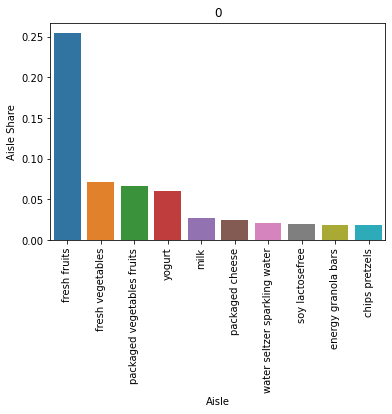

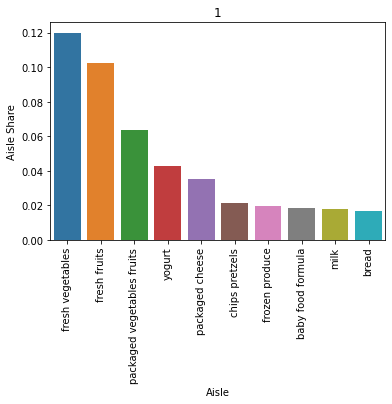

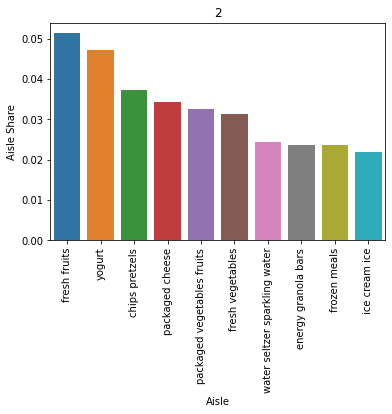

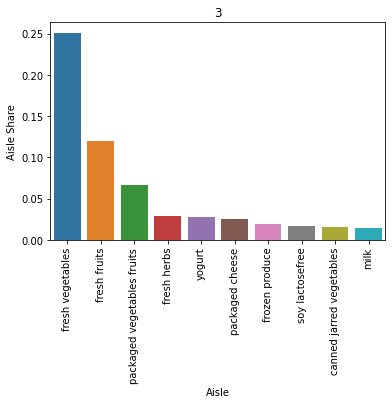

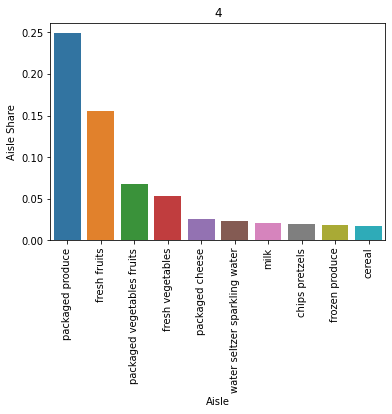

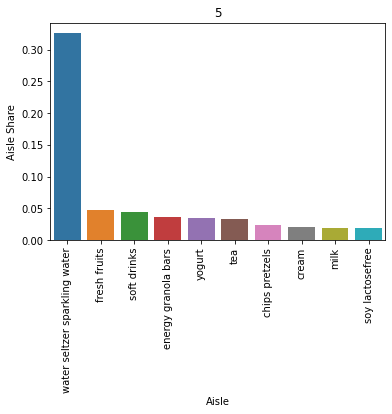

<Figure size 432x288 with 0 Axes>

In [35]:
for i in range(0,6):
    x = sns.barplot(data = cluster_aisle_br[cluster_aisle_br['cluster'] == i].sort_values('aisle_share', ascending = False)[0:10], x = 'aisle', y = 'aisle_share')
    x.set_xticklabels(x.get_xticklabels(), rotation=90)
    plt.title(str(i))
    x.set(xlabel = 'Aisle', ylabel = 'Aisle Share')
    plt.figure()

In [37]:
cluster_dept_br = pd.DataFrame(columns = ['department','add_to_cart_order','dept_share','cluster'])
for i in range(0,6):
    x = dept_history[dept_hist['cluster'] == i]
    x = x.groupby('department')['add_to_cart_order'].sum().reset_index()
    x['dept_share'] = x['add_to_cart_order']
    x['dept_share'] = x['dept_share'].apply(lambda f: f / x['add_to_cart_order'].sum())
    x['cluster'] = i
    cluster_dept_br = pd.concat([x,cluster_dept_br], axis = 0)

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_33292/2674284762.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = dept_history[dept_hist['cluster'] == i]


In [38]:
cluster_dept_br[cluster_dept_br['cluster'] == 5].dept_share.sum()

0.9999999999999999

<AxesSubplot:xlabel='cluster', ylabel='department'>

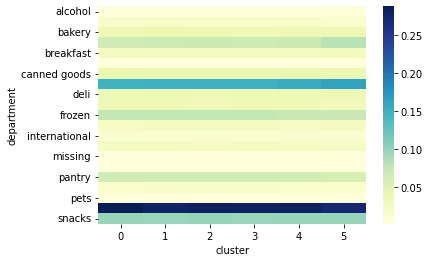

In [39]:
dept_heat = cluster_dept_br.pivot(index = 'department', columns = 'cluster', values = 'dept_share')
sns.heatmap(dept_heat,cmap="YlGnBu")

In [40]:
cluster_dept_br

,department,add_to_cart_order,dept_share,cluster
0,alcohol,7671,0.004386,5
1,babies,24936,0.014257,5
2,bakery,61155,0.034965,5
3,beverages,141737,0.081038,5
4,breakfast,45745,0.026155,5
...,...,...,...,...
16,pantry,847165,0.066436,0
17,personal care,182075,0.014279,0
18,pets,35967,0.002821,0
19,produce,3678718,0.288490,0


In [41]:
pd.DataFrame(cluster_df['cluster'].value_counts().reset_index())

,index,cluster
0,2,73583
1,1,72611
2,3,32845
3,0,15414
4,4,7948
5,5,3808


In [42]:
cluster_df['cluster'].value_counts().sort_index() / cluster_df['cluster'].value_counts().sum() * 100

0     7.474940
1    35.212333
2    35.683700
3    15.928015
4     3.854342
5     1.846670
Name: cluster, dtype: float64

In [43]:
cluster_aisle_br.groupby('cluster')['add_to_cart_order'].sum() / cluster_aisle_br['add_to_cart_order'].sum() * 100

cluster
0     3.674645
1    49.451631
2    29.716858
3    16.011055
4     0.784753
5     0.361059
Name: add_to_cart_order, dtype: object

In [44]:
x = pd.concat([cluster_df['cluster'].value_counts().sort_index() / cluster_df['cluster'].value_counts().sum() * 100,cluster_aisle_br.groupby('cluster')['add_to_cart_order'].sum() / cluster_aisle_br['add_to_cart_order'].sum() * 100], axis = 1)
x.rename(columns = {'cluster':'User Share','add_to_cart_order':'Unit Purchase Share'})

,User Share,Unit Purchase Share
0,7.474940,3.674645
1,35.212333,49.451631
2,35.683700,29.716858
3,15.928015,16.011055
4,3.854342,0.784753
5,1.846670,0.361059


In [45]:
cluster_df.head()

,user_id,0,1,2,3,4,5,cluster
0,1,-0.103161,0.048617,-0.031839,-0.005641,-0.053010,-0.055237,2
1,2,-0.077766,0.077983,-0.076148,-0.101672,0.081783,-0.040413,2
2,3,0.057496,0.085719,0.001778,-0.013192,-0.028501,0.113069,1
3,4,-0.055343,0.134731,-0.002393,-0.037707,-0.087802,-0.027370,0
4,5,0.133936,-0.019591,-0.020960,-0.003732,0.057738,0.138888,1


In [46]:
cluster_aisle_br

,aisle,add_to_cart_order,aisle_share,cluster
0,air fresheners candles,1006,0.000985,5
1,asian foods,3156,0.003089,5
2,baby accessories,108,0.000106,5
3,baby bath body care,72,0.000070,5
4,baby food formula,1180,0.001155,5
...,...,...,...,...
129,trash bags liners,5624,0.000541,0
130,vitamins supplements,12157,0.001169,0
131,water seltzer sparkling water,217689,0.020934,0
132,white wines,2072,0.000199,0


In [52]:
cluster_df.head()

,user_id,0,1,2,3,4,5,cluster
0,1,-0.103161,0.048617,-0.031839,-0.005641,-0.053010,-0.055237,2
1,2,-0.077766,0.077983,-0.076148,-0.101672,0.081783,-0.040413,2
2,3,0.057496,0.085719,0.001778,-0.013192,-0.028501,0.113069,1
3,4,-0.055343,0.134731,-0.002393,-0.037707,-0.087802,-0.027370,0
4,5,0.133936,-0.019591,-0.020960,-0.003732,0.057738,0.138888,1


In [54]:
concat_orders.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id
0,2,33120,1,1,86,16,eggs,dairy eggs,202279
1,2,28985,2,1,83,4,fresh vegetables,produce,202279
2,2,17794,6,1,83,4,fresh vegetables,produce,202279
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279
4,2,9327,3,0,104,13,spices seasonings,pantry,202279


In [47]:
all_orders = concat_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')

In [48]:
all_orders

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,aisle,department,user_id,cluster
0,2,33120,1,1,86,16,eggs,dairy eggs,202279,1
1,2,28985,2,1,83,4,fresh vegetables,produce,202279,1
2,2,17794,6,1,83,4,fresh vegetables,produce,202279,1
3,2,43668,9,0,123,4,packaged vegetables fruits,produce,202279,1
4,2,9327,3,0,104,13,spices seasonings,pantry,202279,1
...,...,...,...,...,...,...,...,...,...,...
33819101,2942910,36885,1,1,134,5,specialty wines champagnes,alcohol,95228,2
33819102,77392,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,2
33819103,679020,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,2
33819104,1264096,47713,1,1,134,5,specialty wines champagnes,alcohol,95228,2


In [50]:
cluster_df.to_csv('../input/cluster_df')

In [51]:
all_orders.to_csv('../input/all_orders.csv')